# Modules, colors, and functions

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
  return false;
}

<IPython.core.display.Javascript object>

In [2]:
# Modules
import statsmodels.api as sm
import scipy as sp
from scipy import sparse, signal, stats
from astropy import convolution as conv
import numpy as np
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt
from matplotlib import colors as clrs
import pandas as pd 
import time
import datetime
import calendar
import seaborn as sns
from copy import deepcopy

import multiprocessing as mp
from multiprocessing.dummy import Pool as ThreadPool

%matplotlib inline 

import sys
sys.path.insert(1, r'functions')  # add to pythonpath
from detect_peaks import detect_peaks


# Color definitions
ClrS = (0.74, 0.00, 0.00)
ClrN = (0.20, 0.56, 1.00)

Clr = [(0.00, 0.00, 0.00),
      (0.31, 0.24, 0.00),
      (0.43, 0.16, 0.49),
      (0.32, 0.70, 0.30),
      (0.45, 0.70, 0.90),
      (1.00, 0.82, 0.67)]

# Font Size

font = {'family': 'sans-serif',
        'weight': 'normal',
        'size'   : 21}

plt.rc('font', **font)

# Histogram and scatter plot
def plotHistSqrtSSN(ax, calRefT, calObsT, maxN):

    # Number of bins to use
    Nbins = np.sqrt(calRefT.shape[0])/5
    Nbins = 20
    
    #calRefT = GDREF/ODREF
    #calObsT = SNdREF
    #calRefT = np.sqrt(calRefT+1)
    #calObsT = np.sqrt(calObsT+1)
    
    #Edges and Centers
    edges = np.arange(1,np.ceil(maxN), (np.ceil(maxN))/Nbins)
    centers = (edges[1:edges.shape[0]] + edges[0:edges.shape[0]-1])/2
    
    # Average group number 
    ax.hist2d(calObsT, calRefT, bins=edges, cmap=plt.cm.magma_r,cmin=1)
    
    # Calculating Quantities for plot
    hist, xedges, yedges = np.histogram2d(calObsT, calRefT, bins=edges)
    xx, yy = np.meshgrid(centers, centers)

    meanY = np.divide(np.sum(np.multiply(hist,xx),axis=1),np.sum(hist,axis=1))
    alphaY = np.sum(hist,axis=1)/np.max(np.sum(hist,axis=1))*0.95+0.05
    
    meanX = np.divide(np.sum(np.multiply(hist,yy),axis=0),np.sum(hist,axis=0))
    alphaX = np.sum(hist,axis=0)/np.max(np.sum(hist,axis=0))*0.95+0.05     
    
    mx, my = np.meshgrid(meanY, meanY)
    
    sDY = np.divide(np.sum(np.multiply(hist,np.power(xx-my,2)),axis=1),np.sum(hist,axis=1))
    
    # Calculating quantities for assessment
    y = meanY
    x = centers
    
    x = x[np.isfinite(y)]
    y = y[np.isfinite(y)]
    

    
    # R squared
    yMean = np.mean(y)    
    SStot = np.sum(np.power(y-yMean,2)) 
    SSreg = np.sum(np.power(y-x,2))
    rSq   = (1 - SSreg/SStot)*sp.stats.pearsonr(x,y)[0]
    
    # Mean Residual
    mRes = np.mean(y-x)
    
    print(meanY)
    print(sDY)
    
    # Plot centers in Y
    for i in range(0, meanY.shape[0]):
        ax.errorbar(centers[i], meanY[i], sDY[i], color='k', zorder=11, alpha=alphaY[i])
        ax.scatter(centers[i], meanY[i], color='w', edgecolor='k', s=100, linewidths = 3, zorder=11, alpha=alphaY[i])

        
    # for i in range(0, meanY.shape[0]):
    #     ax.scatter(meanX[i], centers[i],  color='b', edgecolor='b', s=50, linewidths = 3, zorder=11, alpha=alphaY[i])

    ax.plot(edges, edges, '--'
             , color = Clr[4], linewidth = 3)

    ax.text(0.5, 0.95,'$PCCR$=' + str(np.round(rSq,decimals=2)) + '  MR=' + str(np.round(mRes,decimals=2)), horizontalalignment='center', verticalalignment='center',transform=ax1.transAxes)


# Histogram Outline
def histOutline(dataIn, *args, **kwargs):
    (histIn, binsIn) = np.histogram(dataIn, *args, **kwargs)

    stepSize = binsIn[1] - binsIn[0]

    bins = np.zeros(len(binsIn)*2 + 2, dtype=np.float)
    data = np.zeros(len(binsIn)*2 + 2, dtype=np.float)
    for bb in range(len(binsIn)):
        bins[2*bb + 1] = binsIn[bb]
        bins[2*bb + 2] = binsIn[bb] + stepSize
        if bb < len(histIn):
            data[2*bb + 1] = histIn[bb]
            data[2*bb + 2] = histIn[bb]

    bins[0] = bins[1]
    bins[-1] = bins[-2]
    data[0] = 0
    data[-1] = 0

    return (bins, data)

# Reading SILSO's total sunspot number
We use the current series to separate individual cycles from minimum to minimum. We also identify all the minima present in the reference data, removing the first two minima to isolate potential drifts and systematic errors during the beginning of the RGO era.

In [3]:
SILSO_Sn = pd.read_csv('input_data/SN_m_tot_V2.0.csv', quotechar = '"', encoding = 'ansi', header = 0)
print(SILSO_Sn)
SILSO_Sn['DAY'] = 15+SILSO_Sn['MONTH']*0
#print(15+SILSO_Sn['MONTH']*0)
SILSO_Sn['ORDINAL'] = SILSO_Sn.apply(lambda x: datetime.date(x['YEAR'].astype(int),x['MONTH'].astype(int),x['DAY'].astype(int)).toordinal(),axis=1)
print(SILSO_Sn['ORDINAL'])

#SILSO_Sn_d

      YEAR  MONTH  FRACYEAR  MMEAN  MSTD  NOBS  MARKER
0     1749      1  1749.042   96.7  -1.0    -1       1
1     1749      2  1749.123  104.3  -1.0    -1       1
2     1749      3  1749.204  116.7  -1.0    -1       1
3     1749      4  1749.288   92.8  -1.0    -1       1
4     1749      5  1749.371  141.7  -1.0    -1       1
5     1749      6  1749.455  139.2  -1.0    -1       1
6     1749      7  1749.538  158.0  -1.0    -1       1
7     1749      8  1749.623  110.5  -1.0    -1       1
8     1749      9  1749.707  126.5  -1.0    -1       1
9     1749     10  1749.790  125.8  -1.0    -1       1
10    1749     11  1749.874  264.3  -1.0    -1       1
11    1749     12  1749.958  142.0  -1.0    -1       1
12    1750      1  1750.042  122.2  -1.0    -1       1
13    1750      2  1750.123  126.5  -1.0    -1       1
14    1750      3  1750.204  148.7  -1.0    -1       1
15    1750      4  1750.288  147.2  -1.0    -1       1
16    1750      5  1750.371  150.0  -1.0    -1       1
17    1750

In [4]:
SILSO_Sn = pd.read_csv('input_data/SN_m_tot_V2.0.csv', quotechar = '"', encoding = 'ansi', header = 0)
SILSO_Sn_d = pd.read_csv('input_data/SN_d_tot_V2.0.csv', quotechar = '"', encoding = 'ansi', header = 0)
#print(SILSO_Sn_d)
SILSO_Sn_d['MONTHSN']=SILSO_Sn_d['DAILYSN']
#print(SILSO_Sn_d['MONTHSN'])
#print(SILSO_Sn_d.loc[SILSO_Sn_d['DAILYSN']<0,'MONTHSN'])

#we interpolate with np.interp (x,
#                               xp,
#                               yp)
SILSO_Sn_d.loc[SILSO_Sn_d['DAILYSN']<0,'MONTHSN'] = np.interp(SILSO_Sn_d.loc[SILSO_Sn_d['DAILYSN']<0,'FRACYEAR'],
                                                              SILSO_Sn_d.loc[SILSO_Sn_d['DAILYSN']>=0,'FRACYEAR'],
                                                              SILSO_Sn_d.loc[SILSO_Sn_d['DAILYSN']>=0,'DAILYSN'])

SILSO_Sn_d['DAILYSN'] = SILSO_Sn_d['DAILYSN'].astype(float)
print(SILSO_Sn_d[30:60])

# Smoothing for plotting (365 (not 75 as previous) because if it is daily values)
Gss_1D_ker = conv.Gaussian1DKernel(365)
SILSO_Sn_d['AVGSNd']  = conv.convolve(SILSO_Sn_d['DAILYSN'].values,Gss_1D_ker)

# print(SILSO_Sn_d.loc[SILSO_Sn_d['DAILYSN']<0,'MONTHSN'])

# #SILSO_Sn_d = pd.read_csv('input_data/SN_d_tot_V2.0.csv', quotechar = '"', encoding = 'ansi', header = 0, na_values="-1")
# #print(SILSO_Sn)
# #SILSO_Sn_d['ORDINAL'] = SILSO_Sn_d.apply(lambda x: datetime.date(x['YEAR'].astype(int),x['MONTH'].astype(int),x['DAY'].astype(int)).toordinal(),axis=1)

# # interpolate SILSO daily values from monthly to change -1 (or nan) in DAILYSN column by a certain value
# #identify where there are "-1" values in SILSO daily data and remove the rest
# ordinalnansild1=SILSO_Sn_d['FRACYEAR'].where(SILSO_Sn_d['DAILYSN']<0).dropna()
# print(ordinalnansild1)

# #identify where there are "-1" values in SILSO daily data and remove it
# ordinalnansild2=SILSO_Sn_d['FRACYEAR'].where(SILSO_Sn_d['DAILYSN']>=0).dropna()
# ordinalnansild3=SILSO_Sn_d['DAILYSN'].where(SILSO_Sn_d['DAILYSN']>=0).dropna()
# #print(ordinalnansild2)
# #print(ordinalnansild3)

# #intersild=np.interp(1818.001,ordinalnansild2,ordinalnansild3)
# #obd['SNMonth']=np.interp(ordinalnansild1,ordinalnansild2,ordinalnansild3)
# #print(intersild)
# intersilddf=pd.DataFrame(intersild)
# print(intersilddf)
# #intersild=np.interp(ordinalnansild,SILSO_Sn_d['FRACYEAR'],SILSO_Sn_d['DAILYSN'])
# #intersild=np.interp(SILSO_Sn_d['DAILYSN']<0,SILSO_Sn_d['FRACYEAR'],SILSO_Sn_d['DAILYSN'])


# #intersildcol=np.column_stack(intersild)
# #print(intersildcol)
# intersild1=pd.merge(ordinalnansild1,intersilddf)
# #intersild1=ordinalnansild1.append(intersilddf)
# #intersild1=(ordinalnansild1,intersilddf)
# #intersild1=ordinalnansild1.append(intersild)
# #intersild1 = {'col1': ordinalnansild1, 'col2': intersildcol}
# #intersild1df = pd.DataFrame(data=intersild1)
# print(intersild1)


# # Smoothing
swin = 8 #Smoothing window in months/days
window = signal.gaussian(M=swin*6, std=swin)
window /= window.sum()

SILSO_Sn['MSMOOTH'] = np.convolve(SILSO_Sn['MMEAN'], window, mode='same') #Sn smoothed
#SILSO_Sn_d['DSMOOTH'] = np.convolve(SILSO_Sn_d['DAILYSN'], window, mode='same') #Sn_daily smoothed
#print(SILSO_Sn['MSMOOTH'])

# # Finding maxima and minima
pkMax = detect_peaks(SILSO_Sn['MSMOOTH'], mpd=5) #mpd : detect peaks that are at least separated by minimum peak distance (in number of data-months in this case?)
pkMin = detect_peaks(-SILSO_Sn['MSMOOTH'], mpd=5)
# #print(pkMax)

SIL_max = SILSO_Sn.loc[pkMax, 'MSMOOTH'].values #array maximum amplitudes
SIL_maxT = SILSO_Sn.loc[pkMax, 'FRACYEAR'].values #array maximum dates
# #print(SIL_maxT)

# #the same for minimum
SIL_min = SILSO_Sn.loc[pkMin, 'MSMOOTH'].values
SIL_minT = SILSO_Sn.loc[pkMin, 'FRACYEAR'].values





    YEAR  MONTH  DAY  FRACYEAR  DAILYSN  DAILYSTD  NOBS  MARKER     MONTHSN
30  1818      1   31  1818.084     -1.0      -1.0     0       1   18.714286
31  1818      2    1  1818.086     -1.0      -1.0     0       1   18.285714
32  1818      2    2  1818.089     -1.0      -1.0     0       1   17.642857
33  1818      2    3  1818.092     17.0       5.2     1       1   17.000000
34  1818      2    4  1818.095     -1.0      -1.0     0       1   18.800000
35  1818      2    5  1818.097     20.0       5.7     1       1   20.000000
36  1818      2    6  1818.100     25.0       6.3     1       1   25.000000
37  1818      2    7  1818.103     -1.0      -1.0     0       1   48.250000
38  1818      2    8  1818.105     -1.0      -1.0     0       1   63.750000
39  1818      2    9  1818.108     87.0      11.8     1       1   87.000000
40  1818      2   10  1818.111     -1.0      -1.0     0       1  115.636364
41  1818      2   11  1818.114     -1.0      -1.0     0       1  144.272727
42  1818    

In [5]:
print(SILSO_Sn_d)

       YEAR  MONTH  DAY  FRACYEAR  DAILYSN  DAILYSTD  NOBS  MARKER  \
0      1818      1    1  1818.001     -1.0      -1.0     0       1   
1      1818      1    2  1818.004     -1.0      -1.0     0       1   
2      1818      1    3  1818.007     -1.0      -1.0     0       1   
3      1818      1    4  1818.010     -1.0      -1.0     0       1   
4      1818      1    5  1818.012     -1.0      -1.0     0       1   
5      1818      1    6  1818.015     -1.0      -1.0     0       1   
6      1818      1    7  1818.018     -1.0      -1.0     0       1   
7      1818      1    8  1818.021     65.0      10.2     1       1   
8      1818      1    9  1818.023     -1.0      -1.0     0       1   
9      1818      1   10  1818.026     -1.0      -1.0     0       1   
10     1818      1   11  1818.029     -1.0      -1.0     0       1   
11     1818      1   12  1818.032     -1.0      -1.0     0       1   
12     1818      1   13  1818.034     37.0       7.7     1       1   
13     1818      1  

# Reading Reference data
We use a reduced version of the RGO and Debrecen data as provided by the Heliophysical Observatory, Debrecen . Supplemented during cycle 24 with observations by the Kidslovodsk Mountain Astronomical Station. It has been recast as a table where each corresponds to a single day and the areas of each group for a given day are stored as columns.

We add three more columns to the data:

1. ORDINAL:  number of days after (0001,01,01).
2. FRACYEAR: Fractional year for plotting.
3. SN(v_2.0): daily sunspot number index values 

In [6]:
REF_Dat = pd.read_csv('input_data/SC_SP_RG_DB_KM_group_areas_by_day.csv', quotechar = '"', encoding = 'ansi',header = 0)
REF_Dat['ORDINAL'] = REF_Dat.apply(lambda x: datetime.date(x['YEAR'].astype(int),x['MONTH'].astype(int),x['DAY'].astype(int)).toordinal(),axis=1)
REF_Dat['FRACYEAR'] = REF_Dat.apply(lambda x: x['YEAR'].astype(int)
                                        + (  datetime.date(x['YEAR'].astype(int),x['MONTH'].astype(int),x['DAY'].astype(int)).toordinal()
                                           - datetime.date(x['YEAR'].astype(int),1,1).toordinal() )
                                        / (  datetime.date(x['YEAR'].astype(int)+1,1,1).toordinal()
                                           - datetime.date(x['YEAR'].astype(int),1,1).toordinal() )
                              ,axis=1)


# Turning reference areas into number of groups
oldREF_Grp = REF_Dat[['FRACYEAR','ORDINAL','YEAR','MONTH','DAY']].copy()
oldREF_Grp['GROUPS'] = np.nansum( np.greater(REF_Dat.values[:,3:REF_Dat.values.shape[1]-2],0) ,axis = 1)
oldREF_Grp['GROUPS'] = oldREF_Grp['GROUPS'].astype(float)
oldREF_Grp.loc[np.isnan(REF_Dat['AREA1']), 'GROUPS'] = np.nan

# Smoothing for plotting
Gss_1D_ker = conv.Gaussian1DKernel(75)
oldREF_Grp['AVGROUPS']  = conv.convolve(oldREF_Grp['GROUPS'].values,Gss_1D_ker)


# # max and min amplitudes and dates for RGO
# # Identify minima covered by the reference data
REF_min = SIL_min[np.logical_and(SIL_minT<=np.max(REF_Dat['FRACYEAR']), SIL_minT>=np.min(REF_Dat['FRACYEAR']))]
REF_minT = SIL_minT[np.logical_and(SIL_minT<=np.max(REF_Dat['FRACYEAR']), SIL_minT>=np.min(REF_Dat['FRACYEAR']))]
# #print(REF_minT)

# # Identify maxima covered by the reference data
REF_max = SIL_max[np.logical_and(SIL_maxT<=np.max(REF_Dat['FRACYEAR']), SIL_maxT>=np.min(REF_Dat['FRACYEAR']))]
REF_maxT = SIL_maxT[np.logical_and(SIL_maxT<=np.max(REF_Dat['FRACYEAR']), SIL_maxT>=np.min(REF_Dat['FRACYEAR']))]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]


In [7]:
print(oldREF_Grp)

          FRACYEAR  ORDINAL  YEAR  MONTH  DAY  GROUPS  AVGROUPS
0      1874.290411   684206  1874      4   17     1.0  1.012707
1      1874.293151   684207  1874      4   18     1.0  1.025513
2      1874.295890   684208  1874      4   19     NaN  1.038351
3      1874.298630   684209  1874      4   20     0.0  1.051217
4      1874.301370   684210  1874      4   21     0.0  1.064108
5      1874.304110   684211  1874      4   22     0.0  1.077022
6      1874.306849   684212  1874      4   23     0.0  1.089958
7      1874.309589   684213  1874      4   24     NaN  1.102913
8      1874.312329   684214  1874      4   25     NaN  1.115883
9      1874.315068   684215  1874      4   26     NaN  1.128870
10     1874.317808   684216  1874      4   27     1.0  1.141865
11     1874.320548   684217  1874      4   28     1.0  1.154869
12     1874.323288   684218  1874      4   29     1.0  1.167877
13     1874.326027   684219  1874      4   30     2.0  1.180887
14     1874.328767   684220  1874      5

In [8]:
#print(SILSO_Sn_d)
#print(SILSO_Sn['MSMOOTH'])
#print(oldObsDat)
#print(oldREF_Grp)

cond2=pd.merge(SILSO_Sn_d, oldREF_Grp, on=['YEAR', 'MONTH', 'DAY'], how='inner')
#print(cond1['DAILYSN'])

REF_Grp=oldREF_Grp.join(cond2['AVGSNd'])
#print(ObsDat)
print(REF_Grp[1950:2000])


#condyearsilso=np.where[SILSO_Sn_d['YEAR']=oldObsDat['YEAR']]
#print(condyearsilso)

#cond1=SILSO_Sn_d['YEAR'] == oldObsDat['YEAR']
#cond1

#np.logical_and(SILSO_Sn_d['YEAR'].values==oldObsDat['YEAR'].values,oldREF_Grp['FRACYEAR'].values<=cen[0]+phTol)
#cond1=np.where(SILSO_Sn_d['YEAR'].values==oldObsDat['YEAR'].values)
#print(cond1)


         FRACYEAR  ORDINAL  YEAR  MONTH  DAY  GROUPS  AVGROUPS     AVGSNd
1950  1879.630137   686156  1879      8   19     NaN  0.524625  27.207960
1951  1879.632877   686157  1879      8   20     0.0  0.528167  27.271029
1952  1879.635616   686158  1879      8   21     0.0  0.531728  27.334210
1953  1879.638356   686159  1879      8   22     0.0  0.535310  27.397525
1954  1879.641096   686160  1879      8   23     NaN  0.538911  27.460961
1955  1879.643836   686161  1879      8   24     NaN  0.542532  27.524523
1956  1879.646575   686162  1879      8   25     0.0  0.546172  27.588217
1957  1879.649315   686163  1879      8   26     0.0  0.549829  27.652040
1958  1879.652055   686164  1879      8   27     NaN  0.553506  27.716005
1959  1879.654795   686165  1879      8   28     2.0  0.557203  27.780096
1960  1879.657534   686166  1879      8   29     1.0  0.560915  27.844339
1961  1879.660274   686167  1879      8   30     1.0  0.564647  27.908706
1962  1879.663014   686168  1879      

In [9]:
'''
MoLngt=30

thN=20

# Creating Storing dictionaries
# Monthly sunspot number that meet the consitions
ADREFvaluesI=[]
QDREFvaluesI=[]

#TIdx=0
for TIdx in range(0,thN):
    # Calculating number of groups in reference data for given threshold
    grpsREFw = np.nansum( np.greater(REF_Dat.values[:,3:REF_Dat.values.shape[1]-3],TIdx*thS) ,axis = 1).astype(float)
    #print(grpsREFw)
    grpsREFw[np.isnan(REF_Dat['AREA1'])] = np.nan
    #print(grpsREFw)
    #print(len(grpsREFw))

    TgrpsREF = grpsREFw[0:np.int(grpsREFw.shape[0]/MoLngt)*MoLngt].copy()
    TgrpsREF = TgrpsREF.reshape((-1,MoLngt))
    #print(TgrpsREF)


    #TREFSNd = REF_Grp.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[siInx, 0],ObsDat['FRACYEAR']<endPoints[siInx+1, 0])
    #                             ,'AVGSNd'].values.copy()
    TREFSNd = REF_Grp['AVGSNd'].values.copy()
    #print(TREFSNd)
    TREFSNd = TREFSNd[0:np.int(REF_Grp.shape[0]/MoLngt)*MoLngt].copy()
    #print(TREFSNd)
    TREFSNd = TREFSNd.reshape((-1,MoLngt))
    #print(TREFSNd)


    # Number of days with groups
    GDREF = np.sum(np.greater(TgrpsREF,0),axis=1)
    #print(GDObs[TIdx,SIdx,:])
#    print(GDREF)
#    print(len(GDREF))

    # Number of days with observations
    # REFERENCE
    ODREF= np.sum(np.isfinite(TgrpsREF),axis=1)
#    print(ODREF)
                    
    # Number of quiet days
    # REFERENCE
    QDREF = ODREF-GDREF
#    print(QDREF)

    # ACTIVE DAY FRACTION
    # REFERENCE
    ADFREF = GDREF/ODREF
#    print(ADFREF)

    # monthly (from daily) sunspot number
    SNdREF = np.mean(TREFSNd,axis=1)
#    print(SNdREF)
#    print(len(SNdREF))

    #defining 80% and 20% with respect to the total observations
    #umbhigh = 0.8*ODREF
    #print(umbhigh)
    #umblow = 0.2*ODREF
    #print(umblow)

    #defining AD>80% and choosing the SN value
    #ADREFth=np.greater(GDREF,0.8*ODREF)
    #ADREFth=np.where()
    #ADREFth=np.greater(ADFREF,0.8)
#    print(ADREFth)
    ADREFvalues=SNdREF[np.logical_and(np.logical_and(ADFREF>0.66,ADFREF<1.0), ODREF==MoLngt)]
#    print(ADREFvalues)
#    print(len(ADREFvalues))
    #ADREFvalue=np.min(ADREFvalues)
    #ADREFvaluemean=np.mean(ADREFvalues)
    #print(ADREFvalue)
    #print(ADREFvaluemean)
    #orden=np.sort(ADREFvalues)
    #print(orden)
    
    #defining AD<20% and choosing the SN value    
    #QDREFth=np.greater(QDREF,0.8*ODREF)
    #QDREFth=np.less(ADFREF,0.2)
    #QDREFth=np.where((ADFREF<0.2) & (ODREF==MoLngt))
#    print(QDREFth)
    QDREFvalues=SNdREF[np.logical_and(np.logical_and(ADFREF<0.33,ADFREF>0.0), ODREF==MoLngt)]
#    print(QDREFvalues)
#    print(len(QDREFvalues))
    #QDREFvalue=np.max(QDREFvalues)
    #QDREFvaluemean=np.mean(QDREFvalues) 
    #print(QDREFvalue) 
    #print(QDREFvaluemean) 

    
    #ADREFvaluesI.append(ADREFvalues)
    #QDREFvaluesI.append(QDREFvalues)    
    #print(ADREFvalues)
#print(len(ADREFvalues))
    #print(QDREFvalues)
    
    plt.hist(ADREFvalues, bins=30, rwidth=0.9)  # arguments are passed to np.histogram
    plt.title("Distribution for ADF>0.8 for threshold of " + str(int(TIdx*5)))
    plt.xlabel('Smoothed monthly sunspot number')
    plt.ylabel('Frequency')
    plt.show()

    plt.hist(QDREFvalues, bins=9, rwidth=0.9)  # arguments are passed to np.histogram
    plt.title("Distribution for ADF<0.2 for threshold of " + str(int(TIdx*thS)))
    plt.xlabel('Smoothed monthly sunspot number')
    plt.ylabel('Frequency')
    plt.show()
    
#print(ADREFvalues)
#print(QDREFvalues)
'''

'\nMoLngt=30\n\nthN=20\n\n# Creating Storing dictionaries\n# Monthly sunspot number that meet the consitions\nADREFvaluesI=[]\nQDREFvaluesI=[]\n\n#TIdx=0\nfor TIdx in range(0,thN):\n    # Calculating number of groups in reference data for given threshold\n    grpsREFw = np.nansum( np.greater(REF_Dat.values[:,3:REF_Dat.values.shape[1]-3],TIdx*thS) ,axis = 1).astype(float)\n    #print(grpsREFw)\n    grpsREFw[np.isnan(REF_Dat[\'AREA1\'])] = np.nan\n    #print(grpsREFw)\n    #print(len(grpsREFw))\n\n    TgrpsREF = grpsREFw[0:np.int(grpsREFw.shape[0]/MoLngt)*MoLngt].copy()\n    TgrpsREF = TgrpsREF.reshape((-1,MoLngt))\n    #print(TgrpsREF)\n\n\n    #TREFSNd = REF_Grp.loc[np.logical_and(ObsDat[\'FRACYEAR\']>=endPoints[siInx, 0],ObsDat[\'FRACYEAR\']<endPoints[siInx+1, 0])\n    #                             ,\'AVGSNd\'].values.copy()\n    TREFSNd = REF_Grp[\'AVGSNd\'].values.copy()\n    #print(TREFSNd)\n    TREFSNd = TREFSNd[0:np.int(REF_Grp.shape[0]/MoLngt)*MoLngt].copy()\n    #print(TREFSNd)

In [10]:
MoLngt=30

thN=10
thS=10

# Creating Storing dictionaries
# Number of days with groups
#GDREFI = []  
# Number of days with observations  
#ODREFI = [] 
# Monthly (from daily) sunspot number
#SNdREFI = []

TREFDat = REF_Grp['GROUPS'].values.copy()
TREFSNd = REF_Grp['AVGSNd'].values.copy()

#creating matrix
GDREF = np.zeros((thN,np.int(TREFDat.shape[0]/MoLngt)))
ODREF = np.zeros((thN,np.int(TREFDat.shape[0]/MoLngt)))
SNdREF = np.zeros((thN,np.int(TREFDat.shape[0]/MoLngt)))
#print(GDREF)
#print(len(GDREF))
#print(len(GDREF[0]))

#ADREFvalues = np.zeros((thN,np.int(TgrpsREF.shape[0]/MoLngt))) #mask with zeros
#QDREFvalues = np.zeros((thN,np.int(TgrpsREF.shape[0]/MoLngt))) #mask with zeros

for TIdx in range(0,thN):
#for TIdx in range(0,1):
    # Calculating number of groups in reference data for given threshold
    grpsREFw = np.nansum( np.greater(REF_Dat.values[:,3:REF_Dat.values.shape[1]-3],TIdx*thS) ,axis = 1).astype(float)
    #print(grpsREFw)
    grpsREFw[np.isnan(REF_Dat['AREA1'])] = np.nan
    #print(grpsREFw)
    #print(len(grpsREFw))

    TgrpsREF = grpsREFw[0:np.int(grpsREFw.shape[0]/MoLngt)*MoLngt].copy()
    #print(TgrpsREF)
    #print(len(TgrpsREF))
    TgrpsREF = TgrpsREF.reshape((-1,MoLngt))
    #print(TgrpsREF)
    #print(len(TgrpsREF))
    #print(len(TgrpsREF[0]))


    #TREFSNd = REF_Grp.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[siInx, 0],ObsDat['FRACYEAR']<endPoints[siInx+1, 0])
    #                             ,'AVGSNd'].values.copy()
    #TREFSNd = REF_Grp['AVGSNd'].values.copy()
    #print(TREFSNd)
    TSNdREF = TREFSNd[0:np.int(TREFSNd.shape[0]/MoLngt)*MoLngt].copy()
    #print(TSNdREF)
    #print(len(TSNdREF))
    TSNdREF = TSNdREF.reshape((-1,MoLngt))
    #print(TSNdREF)
    #print(len(TSNdREF))
    #print(len(TSNdREF[0]))
    
    

    # Number of days with groups
    GDREF[TIdx,:] = np.sum(np.greater(TgrpsREF,0),axis=1)
    #print(GDObs[TIdx,SIdx,:])
    #print(GDREF)
    #print(len(GDREF))
    #print(len(GDREF[0]))

    # Number of days with observations
    # REFERENCE
    ODREF[TIdx,:]= np.sum(np.isfinite(TgrpsREF),axis=1)
    #print(ODREF)
    #print(len(GDREF))
                    
    # Number of quiet days
    # REFERENCE
    QDREF = ODREF-GDREF
#    print(QDREF)

    # ACTIVE DAY FRACTION
    # REFERENCE
    ADFREF = GDREF/ODREF
#    print(ADFREF)

    # monthly (from daily) sunspot number
    SNdREF[TIdx,:]=np.mean(TSNdREF,axis=1)
    #print(SNdREF)
    #print(len(SNdREF))

    #defining 80% and 20% with respect to the total observations
    #umbhigh = 0.8*ODREF
    #print(umbhigh)
    #umblow = 0.2*ODREF
    #print(umblow)

    #defining AD>80% and choosing the SN value
    #ADREFth=np.greater(GDREF,0.8*ODREF)
#    ADREFth=np.where((ADFREF>0.8) & (ODREF==MoLngt))
    #ADREFth=np.greater(ADFREF,0.8)
#    print(ADREFth)
#    ADREFvalues=SNdREF[np.logical_and(np.logical_and(ADFREF>0.66,ADFREF<1.0), ODREF==MoLngt)]
#    print(ADREFvalues)
#    print(len(ADREFvalues))
    #ADREFvalue=np.min(ADREFvalues)
    #ADREFvaluemean=np.mean(ADREFvalues)
    #print(ADREFvalue)
    #print(ADREFvaluemean)
    #orden=np.sort(ADREFvalues)
    #print(orden)

    
    #defining AD<20% and choosing the SN value    
    #QDREFth=np.greater(QDREF,0.8*ODREF)
    #QDREFth=np.less(ADFREF,0.2)
#    QDREFth=np.where((ADFREF<0.2) & (ODREF==MoLngt))
#    print(QDREFth)
#    QDREFvalues=SNdREF[np.logical_and(np.logical_and(ADFREF<0.33,ADFREF>0.0), ODREF==MoLngt)]
#    print(QDREFvalues)
#    print(len(QDREFvalues))
    #QDREFvalue=np.max(QDREFvalues)
    #QDREFvaluemean=np.mean(QDREFvalues) 
    #print(QDREFvalue) 
    #print(QDREFvaluemean) 
    

    #GDREFI.append(GDREF)    
    #ODREFI.append(ODREFI) 
    #SNdREFI.append(SNdREFI)

print(GDREF)
print(ODREF)
print(SNdREF)
    #ADREFvaluesI.append(ADREFvalues)
    #QDREFvaluesI.append(QDREFvalues)    


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in true_divide


[[21. 25. 30. ... 27. 24. 19.]
 [21. 25. 30. ... 27. 24. 14.]
 [21. 25. 30. ... 24. 23. 11.]
 ...
 [21. 22. 30. ... 13. 16.  6.]
 [21. 22. 30. ... 11. 16.  6.]
 [21. 22. 30. ...  8. 16.  5.]]
[[25. 27. 30. ... 27. 24. 19.]
 [25. 27. 30. ... 27. 24. 19.]
 [25. 27. 30. ... 27. 24. 19.]
 ...
 [25. 27. 30. ... 27. 24. 19.]
 [25. 27. 30. ... 27. 24. 19.]
 [25. 27. 30. ... 27. 24. 19.]]
[[80.22895405 76.92409748 73.6859341  ... 36.79338157 34.95211195
  33.16301935]
 [80.22895405 76.92409748 73.6859341  ... 36.79338157 34.95211195
  33.16301935]
 [80.22895405 76.92409748 73.6859341  ... 36.79338157 34.95211195
  33.16301935]
 ...
 [80.22895405 76.92409748 73.6859341  ... 36.79338157 34.95211195
  33.16301935]
 [80.22895405 76.92409748 73.6859341  ... 36.79338157 34.95211195
  33.16301935]
 [80.22895405 76.92409748 73.6859341  ... 36.79338157 34.95211195
  33.16301935]]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in less
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:114: RuntimeWarning: invalid value encountered in less


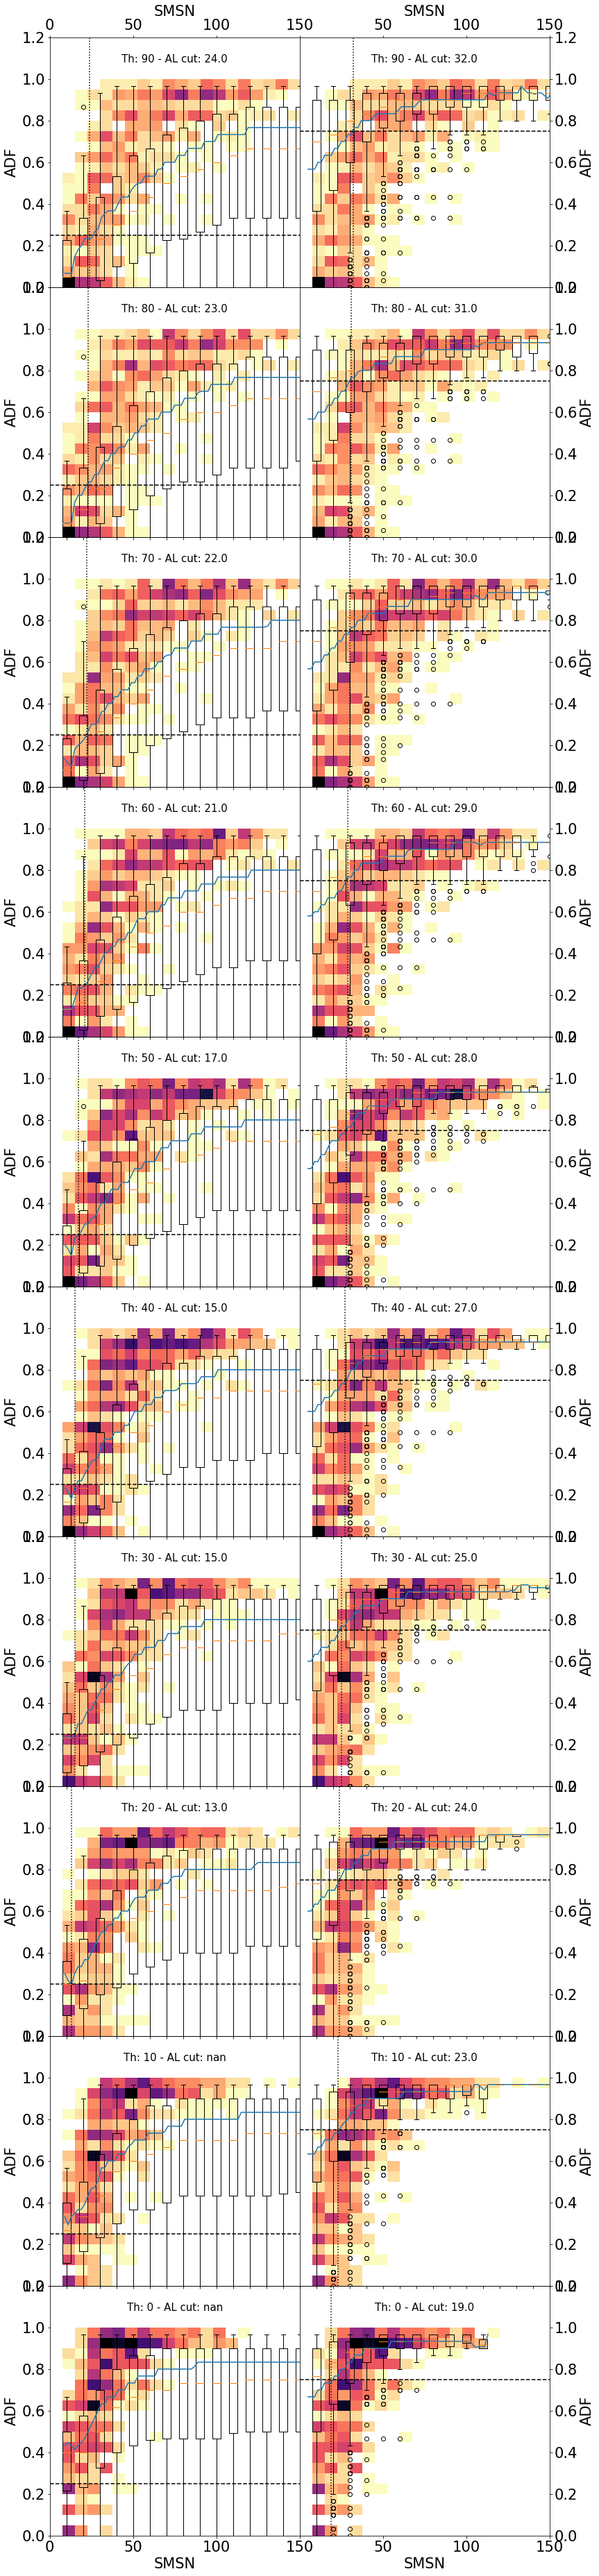

In [36]:
           
plt.rc('font', **font)
    
# Size definitions
dpi = 300
pxx = 1500   # Horizontal size of each panel
pxy = pxx    # Vertical size of each panel
frc = 1    # Fraction of the panel devoted to histograms

nph = 2      # Number of horizontal panels
npv = thN      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units

Nbinsx = 20
Nbinsy = 20

edgesx = np.arange(0,Nbinsy+1)/Nbinsy*150
edgesy = np.arange(0,Nbinsy+1)/Nbinsy

bprange = np.arange(10,175,10)
pprange = np.arange(5,175,2)
pctl=60

ADFREF = np.divide(GDREF,ODREF)
calObsT = SNdREF

maxN = np.max([np.nanmax(ADFREF),np.nanmax(calObsT)])

## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))

#for n in range(0,20):

LowALlim = np.zeros(thN)
HighALlim = np.zeros(thN)


for n in range(0,thN): #thN=10
    
    #pltmsk = np.logical_and(ODREF[n,:]==MoLngt, np.logical_and(ADFREF[n,:]>0,ADFREF[n,:]<1))
    #pltmsk = ODREF[n,:]==MoLngt
    pltmsk = np.logical_and(ODREF[n,:]==MoLngt,ADFREF[n,:]<1)

    #ax1
    ax1 = fig.add_axes([ppadh, ppadv+n*pxy/fszv, pxx/fszh, pxy/fszv], label= 'b1')
    ax1.hist2d(SNdREF[n,:][pltmsk], ADFREF[n,:][pltmsk], bins=[edgesx,edgesy], cmap=plt.cm.magma_r,cmin=1) 

    bpdat = []
    
    for AL in bprange:
        bpdat.append(ADFREF[n,:][np.logical_and(pltmsk, SNdREF[n,:]<=AL)])
        
    ax1.boxplot(bpdat, positions=bprange, widths=5)
    
    ALP = pprange*np.nan
    for ALi in np.arange(0,pprange.shape[0]):
        if (np.sum(np.logical_and(pltmsk, SNdREF[n,:]<=pprange[ALi]))>0):ALP[ALi] = np.percentile(ADFREF[n,:][np.logical_and(pltmsk, SNdREF[n,:]<=pprange[ALi])], pctl)

    ax1.plot(pprange, ALP)
    ax1.plot([0,150],[0.25,0.25],color='k',linestyle='--')
    
    intrsc = np.where(np.abs(ALP-0.25)==np.nanmin(np.abs(ALP-0.25)))[0]
    cut = np.mean(pprange[intrsc])        
    if np.sum(ALP<0.25)==0:
        cut = np.nan
    
    LowALlim[n] = cut
    
    ax1.plot([cut,cut],[0,1.2],color='k',linestyle=':')

    
    # Axes properties
    ax1.text(0.5, 0.9,'Th: ' + str(n*thS) + ' - AL cut: ' + str(cut), horizontalalignment='center',fontsize=15,transform = ax1.transAxes)
    ax1.set_ylabel('ADF')
    ax1.set_ylim(top=1.2,bottom=0)
    ax1.set_xlim(left = 0, right=150)
    

    #ax2
    ax2 = fig.add_axes([ppadh+pxx/fszh, ppadv+n*pxy/fszv, pxx/fszh, pxy/fszv], label= 'b2')
    ax2.hist2d(SNdREF[n,:][pltmsk], ADFREF[n,:][pltmsk], bins=[edgesx,edgesy], cmap=plt.cm.magma_r,cmin=1)
    
    bpdat = []
    for AL in bprange:        
        bpdat.append(ADFREF[n,:][np.logical_and(pltmsk, SNdREF[n,:]>=AL)])
    
    ax2.boxplot(bpdat, positions=bprange, widths=5)
    
    ALP = pprange*np.nan
    for ALi in np.arange(0,pprange.shape[0]):
        if (np.sum(np.logical_and(pltmsk, SNdREF[n,:]>=pprange[ALi]))>0):ALP[ALi] = np.percentile(ADFREF[n,:][np.logical_and(pltmsk, SNdREF[n,:]>=pprange[ALi])], 100-pctl)

    ax2.plot(pprange, ALP)
    ax2.plot([0,150],[0.75,0.75],color='k',linestyle='--')
    
    intrsc = np.where(np.abs(ALP-0.75)==np.nanmin(np.abs(ALP-0.75)))[0]
    cut = np.mean(pprange[intrsc])
        
    if np.sum(ALP<0.75)==0:
        cut = np.nan
        
    HighALlim[n] = cut    

    ax2.plot([cut,cut],[0,1.2],color='k',linestyle=':')

        
    # Axes properties
    ax2.set_ylabel('ADF')
    ax2.yaxis.set_label_position("right")
    ax2.text(0.5, 0.9,'Th: ' + str(n*thS) + ' - AL cut: ' + str(cut), horizontalalignment='center',fontsize=15,transform = ax2.transAxes)
    ax2.set_ylim(top=1.2,bottom=0)
    
    ax2.yaxis.tick_right()
    ax2.set_xlim(left = 0, right=150)
            
    if n>0&n<thN-1:
        ax1.set_xticklabels([])
        ax2.set_xticklabels([])        
    else:
        ax1.set_xlabel('SMSN')
        ax2.set_xlabel('SMSN')
        ax1.set_xticks([0,50,100,150])
        ax1.set_xticklabels([0,50,100,150])
        ax2.set_xticks([50,100,150])
        ax2.set_xticklabels([50,100,150])
        
    if n==thN-1:
        ax1.xaxis.set_label_position("top")
        ax1.xaxis.tick_top()
        ax2.xaxis.tick_top()
        ax2.xaxis.set_label_position("top")
        ax1.set_xlabel('SMSN')
        ax2.set_xlabel('SMSN')
        ax1.set_xticks([0,50,100,150])
        ax1.set_xticklabels([0,50,100,150])
        ax2.set_xticks([50,100,150])
        ax2.set_xticklabels([50,100,150])


In [37]:
LowALlim

array([nan, nan, 13., 15., 15., 17., 21., 22., 23., 24.])

[0.16904762 9.45238095]
[ 0.13090909 20.90909091]


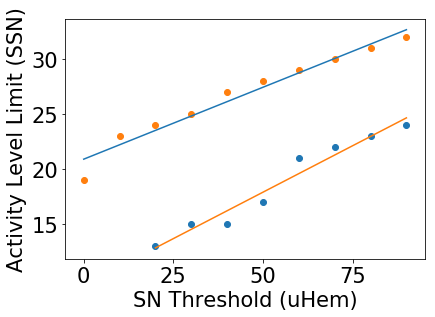

In [38]:
# fit for low solar activity
xlow = np.arange(0,thN)*thS
xlow = xlow[np.isfinite(LowALlim)]
ylow = LowALlim[np.isfinite(LowALlim)]
fitlow = np.polyfit(xlow,ylow,deg=1)
print(fitlow)

# fit for high solar activity
xhigh = np.arange(0,thN)*thS
xhigh = xhigh[np.isfinite(HighALlim)]
yhigh = HighALlim[np.isfinite(HighALlim)]
fithigh = np.polyfit(xhigh,yhigh,deg=1)
print(fithigh)


plt.rc('font', **font)
    
# Size definitions
dpi = 300
pxx = 1500   # Horizontal size of each panel
pxy = 1000    # Vertical size of each panel
frc = 1    # Fraction of the panel devoted to histograms

nph = 1      # Number of horizontal panels
npv = 1      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units

## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))
ax1 = fig.add_axes([ppadh, ppadv, pxx/fszh, pxy/fszv])



ax1.scatter(xlow, ylow, alpha=1)
ax1.scatter(xhigh, yhigh,alpha=1)
ax1.plot(xhigh,fithigh[0]*xhigh+fithigh[1])
ax1.plot(xlow,fitlow[0]*xlow+fitlow[1])

ax1.set_xlabel('SN Threshold (uHem)')
ax1.set_ylabel('Activity Level Limit (SSN)');
